<a href="https://www.kaggle.com/code/aletbm/titanic-analisys-with-ml?scriptVersionId=107904204" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import RobustScaler
from scipy.stats import uniform, randint

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import xgboost as xgb

import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

import re

---
### Acquire data

The Python Pandas packages help us work with our datasets. This way, we will transform our train and test datasets into Pandas Dataframe ables to run certain operations.

In [3]:
train = pd.read_csv("../input/titanic/train.csv")
test = pd.read_csv("../input/titanic/test.csv")
dataset = [train.copy(), test.copy()]

We run some operations to obtain dataset preview.

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


Both datasets contain object type feature, these feature should be proccesed later. Futhermore, some features contain severals NaN data, this is a problem that we must solve.

In [6]:
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [7]:
test.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S


## Preparing the dataset for visualization

### Converting categorical feature into numerical feature for the visualization stage
Let's get the features that are of object type.

In [8]:
cat = dataset[0].columns.to_series().groupby(dataset[0].dtypes).groups.get(np.dtype('O'))
cat

Index(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], dtype='object')

These are the categorical features on which we will work it. According to exposed [here](https://triangleinequality.wordpress.com/2013/09/08/basic-feature-engineering-with-the-titanic-data/), the title from the name is an important feature for the prediction so that we'll try to process this information to obtain a numerical feature. Also, the raw feature name is a difficult feature to correlate with the label output since each row represent a different category and this is not useful. In the previous blog they give us an idea to process these names, It basically consist of observing the title that each person receive, let's see which ones exist:

In [9]:
for one_set in dataset:
    one_set['Title'] = one_set["Name"].str.extract(' ([A-Za-z]+)\.', expand=False)
pd.DataFrame({"Amount":dataset[0]['Title'].value_counts(),
                "%":dataset[0]['Title'].value_counts()*100/dataset[0].shape[0]}, index=dataset[0]['Title'].value_counts().keys())

,Amount,%
Mr,517,58.024691
Miss,182,20.426487
Mrs,125,14.029181
Master,40,4.489338
Dr,7,0.785634
Rev,6,0.673401
Mlle,2,0.224467
Major,2,0.224467
Col,2,0.224467
Countess,1,0.112233


Well, we are insterested in the four top most frequent titles, these are Mr, Miss, Mrs and Master, the rest we will group them in a category called "Other". Based on this we will assing them each category a number to convert this feature into a numerical feature.

Let's keep in mind that "Mlle" is "Mademoiselle" which is synonym for "Miss", the same can be observed for Mme = Mrs and Ms = Miss.

In [10]:
for one_set in dataset:
    one_set["Title"].replace(["Dr", "Rev", "Major",
                                "Col", "Countess", "Capt", 
                                "Sir", "Lady", "Don", "Jonkheer"], "Other", inplace=True)
    one_set["Title"].replace("Ms", "Miss", inplace=True)
    one_set["Title"].replace("Mme", "Mrs", inplace=True)
    one_set["Title"].replace("Mlle", "Miss", inplace=True)
dataset[0]['Title'].value_counts()

Mr        517
Miss      185
Mrs       126
Master     40
Other      23
Name: Title, dtype: int64

Finally, we have these five categories to which we will assign a number so that estimators can to process them.

In [11]:
title_map = {"Mr":1, "Miss":2, "Mrs":3, "Master":4, "Other":0}
for one_set in dataset:
    one_set["Title"] = one_set["Title"].map(title_map)
    one_set['Title'] = one_set['Title'].fillna(0)
dataset[0]["Title"]

0      1
1      3
2      2
3      3
4      1
      ..
886    0
887    2
888    2
889    1
890    1
Name: Title, Length: 891, dtype: int64

Thus, we can now leave out the "Name" feature.

In [12]:
print(f"Null data percentage in Cabin: { (dataset[0].loc[dataset[0]['Cabin'].isna()]['Cabin'].shape[0]/dataset[0].shape[0])*100}")

Null data percentage in Cabin: 77.10437710437711


Two important observations:
+ "Ticket" is a feature that has many categories, and for practical purposes the passanger's ticket number is irrelevant in determining whether or not the passanger will survive, the ticket number in some cases presents a serie of letters, numbers and signs, and in other cases it simply present a series of numbers, It is not is a reliable data so it will be to discarded.
+ "Cabin" is a feature that presents many NaN data, more exactly 77.1% of the examples that compose it are NaN, so it will be to discarded.

---
### Completing features:

Before we continue with visualization, we must fill in the features has NaN values. Come on what are they:

In [13]:
dataset[0].isna().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
Title          False
dtype: bool

In [14]:
dataset[1].isna().any()

PassengerId    False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare            True
Cabin           True
Embarked       False
Title          False
dtype: bool

We see that both dataset has missing values, more precisely in Age, Fare, Cabin and Embarked. Let's work age first, to fill these missing data a good way is asign mean value of all the ages to the missing values, in this way we will not affect the average value of the dataset.

In [15]:
for one_set in dataset:
    one_set.loc[one_set["Age"].isna(), "Age"] = one_set["Age"].mean()
dataset[0].isna().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age            False
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
Title          False
dtype: bool

The same we can do with the "Fare" in the test set.

In [16]:
dataset[1].loc[dataset[1]["Fare"].isna(), "Fare"] = dataset[1]["Fare"].mean()
dataset[1].isna().any()

PassengerId    False
Pclass         False
Name           False
Sex            False
Age            False
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked       False
Title          False
dtype: bool

To complete the missing values in "Embarked" of the training set, what we will do is assign the most frequent value since the much difference between the different categories is so great and the missing data is so few that we will not cause large changes in the prediction:

In [17]:
dataset[0]["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [18]:
dataset[0].loc[dataset[0]["Embarked"].isna(), "Embarked"] = "S"
dataset[0].isna().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age            False
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked       False
Title          False
dtype: bool

As we said, "Cabin" presents a 77% of NaN data, these are too missing data, the best we can do is leave out this feature, futhermore, it is a feature that presents too categories and this makes it difficult to analyze.

---
## Percentage ratios:

#### Percentage of men and women in the training set:

In [19]:
pd.DataFrame({"Amount":dataset[0]['Sex'].value_counts(),
                "%":dataset[0]['Sex'].value_counts()*100/dataset[0].shape[0]}, index=dataset[0]['Sex'].value_counts().keys())

,Amount,%
male,577,64.758698
female,314,35.241302


In [20]:
dataset[0][['Sex', 'Survived']].groupby(['Sex']).mean()

,Survived
Sex,
female,0.742038
male,0.188908


The "Sex" feature seems to be a determining factor in predicting whether or not and individual will survive, the women have a markedly greater probability of surviving than men, this is obvious because of during the sinking the lives women and children were priorized.

#### Percentage of survivors by passanger class in the training set:

In [21]:
dataset[0][['Pclass', 'Survived']].groupby(['Pclass']).mean()

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


It is quite obvious that the first-class passangers had most probabilities of surviving than the rest passanger classes. Therefore, this feature so will be importante for the prediction.

#### Percentage of survivors by port of embarkation in the dataset:

In [22]:
dataset[0][['Embarked', 'Sex', 'Pclass', 'Survived']].groupby(['Sex', 'Pclass','Embarked']).mean()

Survived
Sex    Pclass Embarked          
female 1      C         0.976744
              Q         1.000000
              S         0.960000
       2      C         1.000000
              Q         1.000000
              S         0.910448
       3      C         0.652174
              Q         0.727273
              S         0.375000
male   1      C         0.404762
              Q         0.000000
              S         0.354430
       2      C         0.200000
              Q         0.000000
              S         0.154639
       3      C         0.232558
              Q         0.076923
              S         0.128302

The "Embarked" feature is important to determine whether or not individual will survive, we can see that in some cases the percentage of survivors is 100% and other cases it is 0%.

#### Percentages for accompanied passengers or lonely passangers:

In [23]:
pd.DataFrame({"Amount":dataset[0]['SibSp'].value_counts(),
                "%":dataset[0]['SibSp'].value_counts()*100/dataset[0].shape[0]}, index=dataset[0]['SibSp'].value_counts().keys())

,Amount,%
0,608,68.237935
1,209,23.456790
2,28,3.142536
4,18,2.020202
3,16,1.795735
8,7,0.785634
5,5,0.561167


We can see that more than half of the passengers boarded alone. And a third of the passengers on board with a brother/spouse.

In [24]:
dataset[0][['SibSp', 'Survived']].groupby(['SibSp']).mean()

,Survived
SibSp,
0,0.345395
1,0.535885
2,0.464286
3,0.250000
4,0.166667
5,0.000000
8,0.000000


However, the group of people who shipped with one or two siblings/spouse had a better percentage of survivors than with the group of people who shipped with no siblings/spouse, beforehand we could ay that shipped with a companion is imporatant for predict whether or not individual will survive but, however, when we see the group of passangers who shipped with more than two siblings/spouse, the percentage of survivors is lower, even in some cases it is null.

In [25]:
pd.DataFrame({"Amount":dataset[0]['Parch'].value_counts(),
                "%":dataset[0]['Parch'].value_counts()*100/dataset[0].shape[0]}, index=dataset[0]['Parch'].value_counts().keys())

,Amount,%
0,678,76.094276
1,118,13.243547
2,80,8.978676
5,5,0.561167
3,5,0.561167
4,4,0.448934
6,1,0.112233


Something similar can be observed with respect to the percentage of passangers who shipped without children, which is more than 50% of the passangers.

In [26]:
dataset[0][['Parch', 'Survived']].groupby(['Parch']).mean()

,Survived
Parch,
0,0.343658
1,0.550847
2,0.500000
3,0.600000
4,0.000000
5,0.200000
6,0.000000


Something similar happens to what is observed with "SibSp" features. In short, there is a greater chance of survival if the individual doesn't board the ship alone. This will require create a new feature that define this situation and perhaps we can leave out of the "SibSp" and "Parch" features.

---

## Data Visualization

#### Percentage of survivors

In [27]:
colors = ['gold', 'mediumturquoise']
labels = ['0','1']
values = dataset[0]['Survived'].value_counts()

fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.update_layout(
    title_text="Survived")
fig.show()

#### Features by condition of survival

<Figure size 576x396 with 0 Axes>

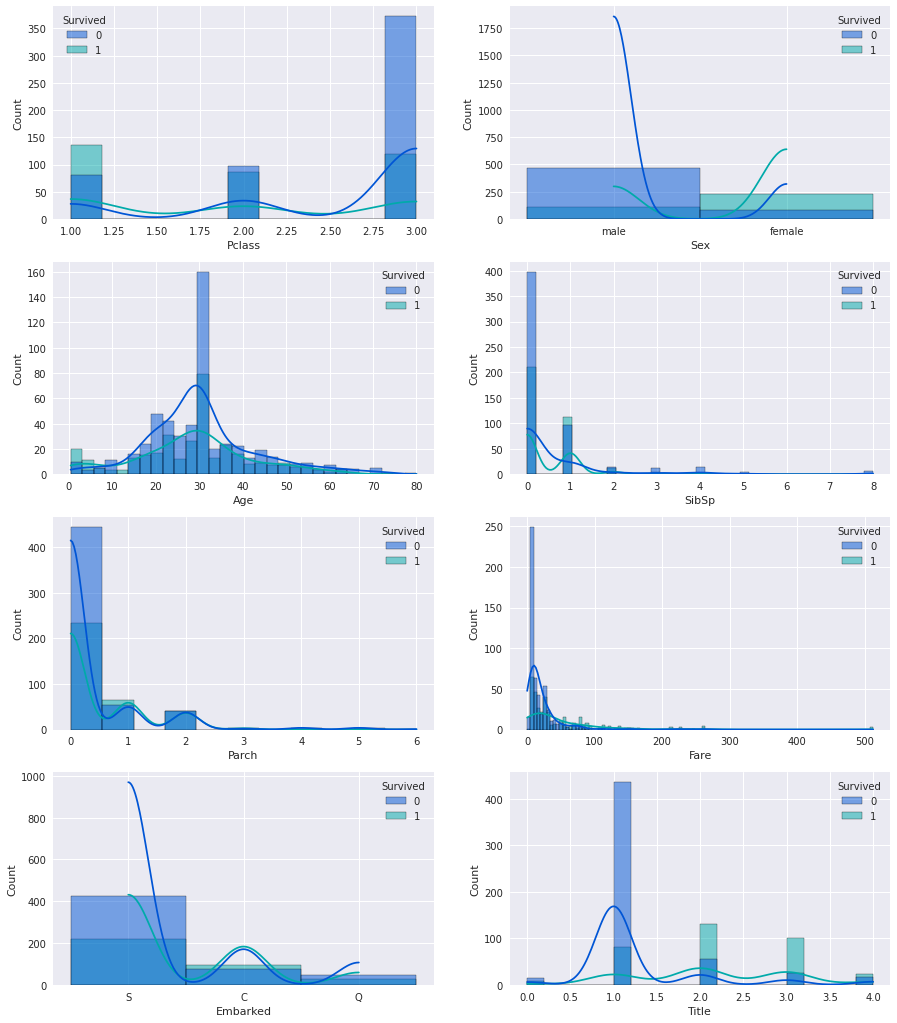

In [28]:
plt.style.use("seaborn")
sns.set_palette("bright")
plt.subplots_adjust(hspace=0.2)
color = 'winter'

fig,axs = plt.subplots(4,2, figsize = (15,18))
i=1
for feature in dataset[0].columns:
    if feature not in ["PassengerId", "Survived", "Name", "Ticket", "Cabin"]:
        plt.subplot(4,2,i)
        sns.histplot(data=dataset[0], x=feature, kde=True, palette=color, hue='Survived')
        i+=1

Important observations:
+ The highest number of deaths corresponds to the third class passengers, the second class passangers have a more balanced situation and the first class passangers have a highest number of survivors.
+ We also confirmed that the highest number of deaths was of male passangers.
+ A large majority of the passangers were between 20 to 30 years of age, in addition, we can observe that for passangers under 16 years of age the curve of survivors tends to be greater than that the curve of deaths.
+ The highest number of deaths corresponds to lonely passangers.
+ A large majority of the passangers who did not survive paid a fare of less than 50. We also see atypical cases where some passangers paid a fare greater than 200.
+ A large part of the passangers shipped the Titanic in the port of Southampton, where more than half of these passangers did not survive. The passangers that shipped in the port of Queenstown more than half of these passangers did survive. We will see later why this is so.

#### Features by condition of sex

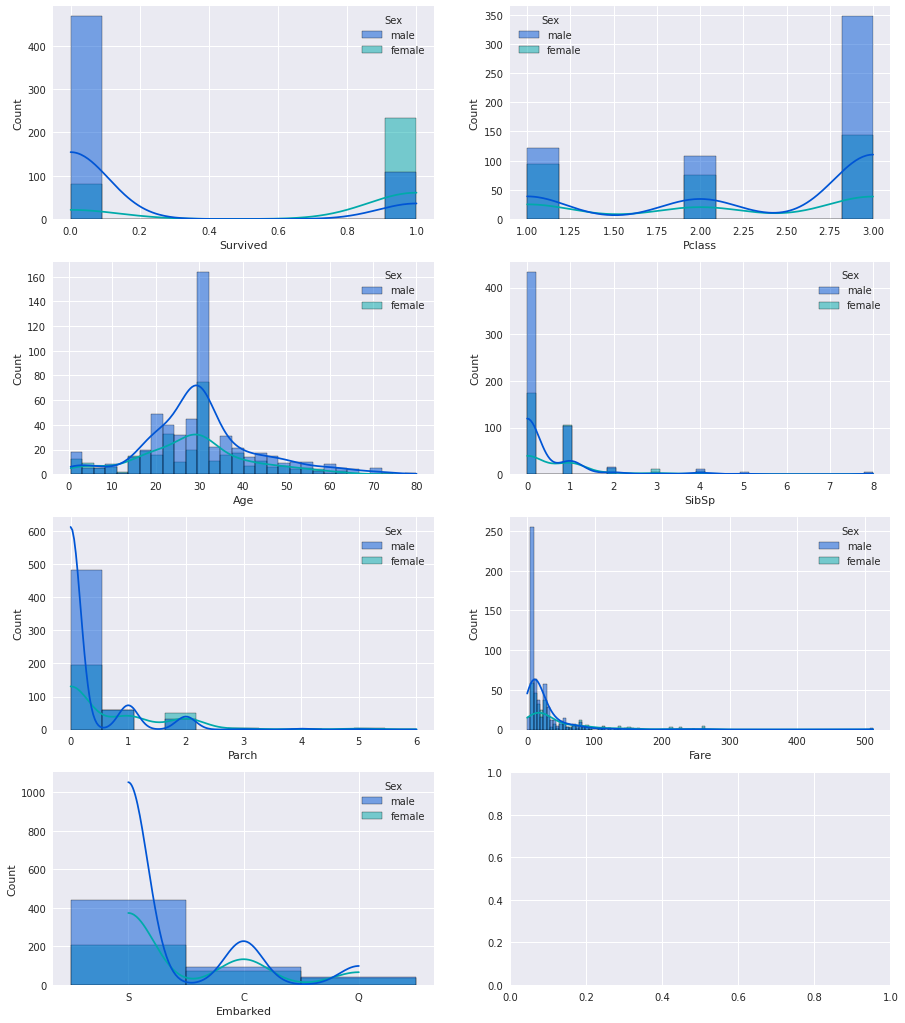

In [29]:
fig,axs = plt.subplots(4,2, figsize = (15,18))
i=1
for feature in dataset[0].columns:
    if feature not in ["PassengerId", "Sex", "Name", "Ticket", "Cabin", "Title"]:
        plt.subplot(4,2,i)
        sns.histplot(data=dataset[0], x=feature, kde=True, palette=color, hue='Sex')
        i+=1

Important observations:
+ As we already mentioned the large part of survivors were women, less than half of the survivors were men.
+ In all passangers classes the large part of deaths were men, mostly male passangers of the third class.
+ The mode in the age of men was around 25 to 30 years, while that the mode in the age of women was around 20 to 25 years.
+ The percentage of lonely men were higher than that the percentage of lonely women.
+ On fare issues, for both men and women, the majority paid a rate of less than 50.
+ For both men and women, the majority on board in the port of Southampton.

#### Features by condition of passanger class 

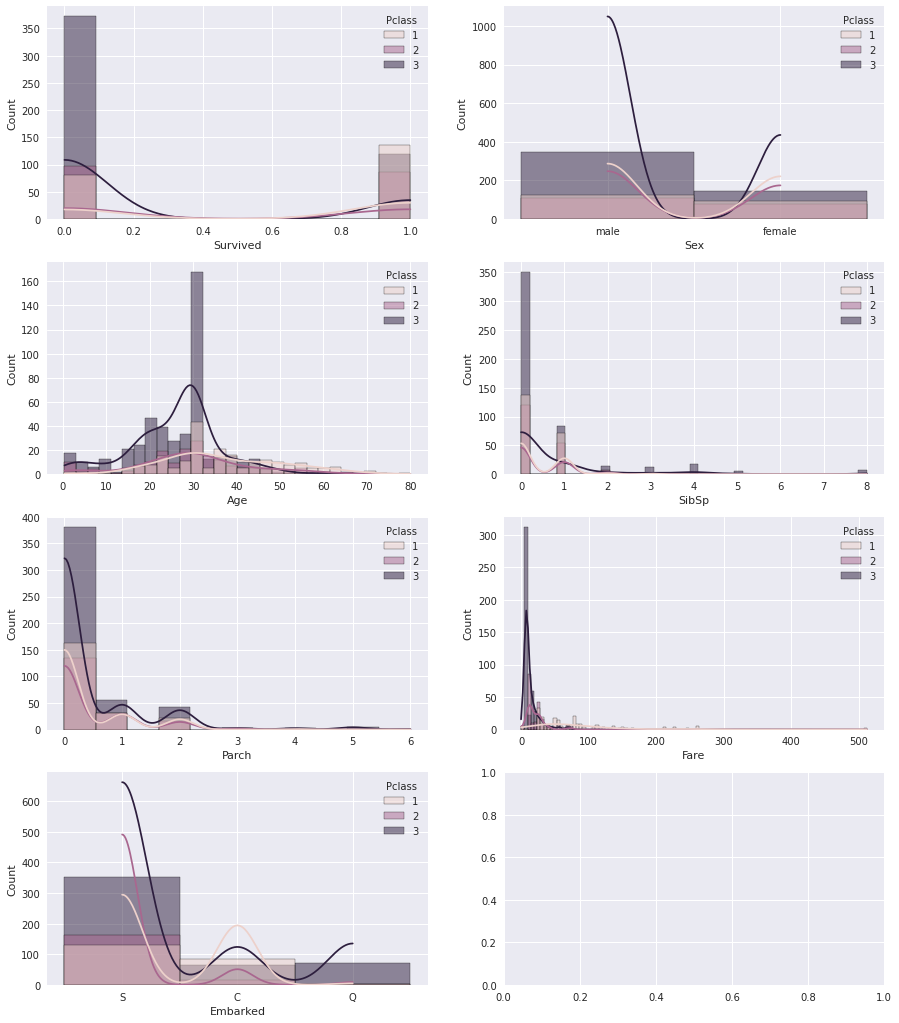

In [30]:
fig,axs = plt.subplots(4,2, figsize = (15,18))
i=1
for feature in dataset[0].columns:
    if feature not in ["PassengerId", "Pclass", "Name", "Ticket", "Cabin", "Title"]:
        plt.subplot(4,2,i)
        sns.histplot(data=dataset[0], x=feature, kde=True, hue='Pclass')
        i+=1

Important observation:
+ As we already mentioned, the large part of deaths correspond to the third class passangers, but incredibly they were also the passanger with the largets number of survivors, perhaps this is due to the disproportinate number of passangers that correspond to the third class.
+ The largest population were male passangers of the third class.
+ We can see how the average age of the passsangers was higher the better the class of the ticket, the third class passangers had a mode between 20 to 25 years, the mode for second class passangers was between 25 to 35 years and the mode for first class passangers was between 35 to 40 years. This clearly reflects a relation between the age and the individual's economy.
+ The large part of lonely men correspond to the third class.
+ And as it was obvious, the third class passanger paid lower fares than the second and first class passangers. There are cases where third class passanger paid higher fares than the second and first class passangers.
+ Finally, we said that of the passangers who boarded at the port of Queenstown more than half survived, this was precisely because the vast majority of those who boarded at that port were first class passangers.

#### Features by age of the passangers:

In [31]:
for one_set in dataset:
    one_set["AgeBand"] = 1
    one_set.loc[ one_set['Age'] <= 16, 'AgeBand'] = 1
    one_set.loc[(one_set['Age'] > 16) & (one_set['Age'] <= 32), 'AgeBand'] = 2
    one_set.loc[(one_set['Age'] > 32) & (one_set['Age'] <= 48), 'AgeBand'] = 3
    one_set.loc[(one_set['Age'] > 48) & (one_set['Age'] <= 64), 'AgeBand'] = 4
    one_set.loc[ one_set['Age'] > 64, 'AgeBand'] = 5

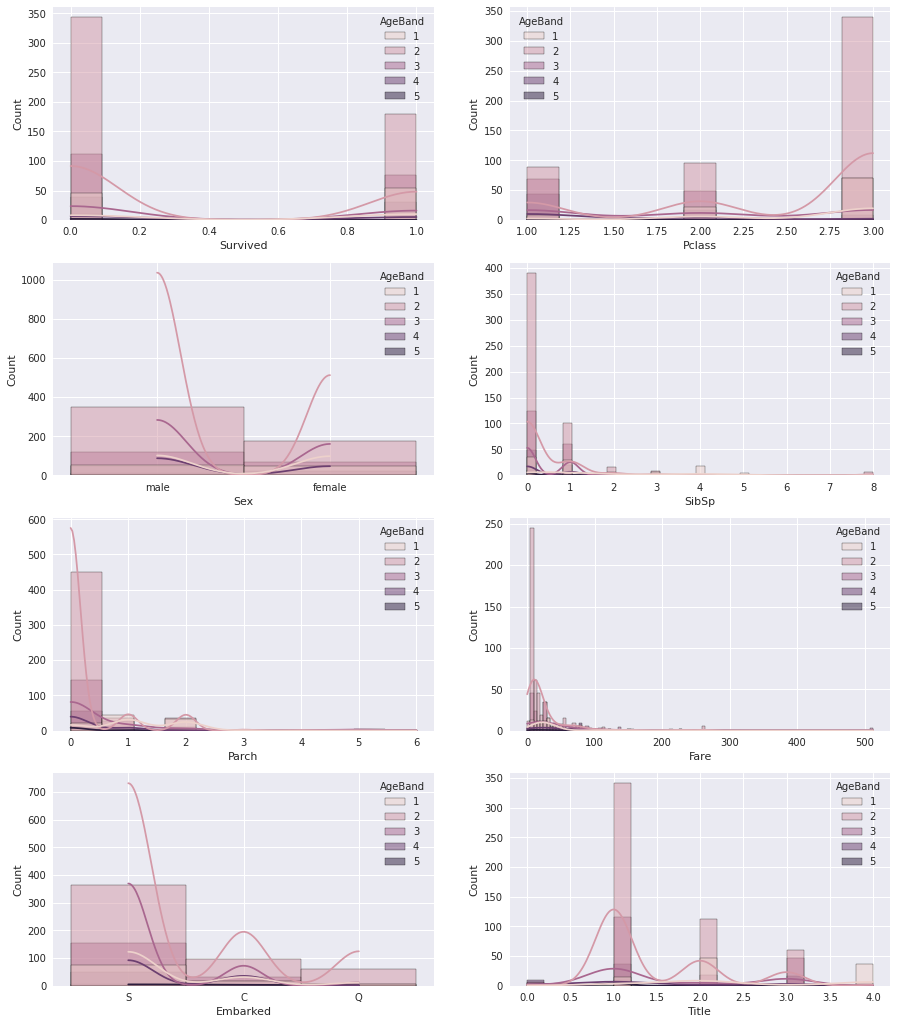

In [32]:
fig,axs = plt.subplots(4,2, figsize = (15,18))
i=1
for feature in dataset[0].columns:
    if feature not in ["PassengerId", "Name", "Ticket", "Cabin", "FareGroup", "Age", "AgeBand"]:
        plt.subplot(4,2,i)
        sns.histplot(data=dataset[0], x=feature, kde=True, hue='AgeBand')
        i+=1

#### Features by price of the fare:
I would like to see the relations regarding the fare, for this I will implement a new feature that will try to reduce the number of categories that "Fare" contains. We will take the values of the quartiles to define classification limits.

In [33]:
low_cost = dataset[0]["Fare"].describe()["25%"]
medium_cost = dataset[0]["Fare"].describe()["50%"]
expensive = dataset[0]["Fare"].describe()["75%"]

for one_set in dataset:
    one_set["FareGroup"] = "Low"
    one_set.loc[(one_set["Fare"] > low_cost) & (one_set["Fare"] <= medium_cost), "FareGroup"] = "Standard"
    one_set.loc[(one_set["Fare"] > medium_cost) & (one_set["Fare"] <= expensive), "FareGroup"] = "Expensive"
    one_set.loc[one_set["Fare"] > expensive, "FareGroup"] = "Too Expensive"
dataset[0]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,AgeBand,FareGroup
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,NaN,S,1,2,Low
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,C,3,3,Too Expensive
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S,2,2,Standard
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,S,3,3,Too Expensive
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,NaN,S,1,3,Standard
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.000000,0,0,211536,13.0000,NaN,S,0,2,Standard
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,112053,30.0000,B42,S,2,2,Expensive
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,29.699118,1,2,W./C. 6607,23.4500,NaN,S,2,2,Expensive
889,890,1,1,"Behr, Mr. Karl Howell",male,26.000000,0,0,111369,30.0000,C148,C,1,2,Expensive


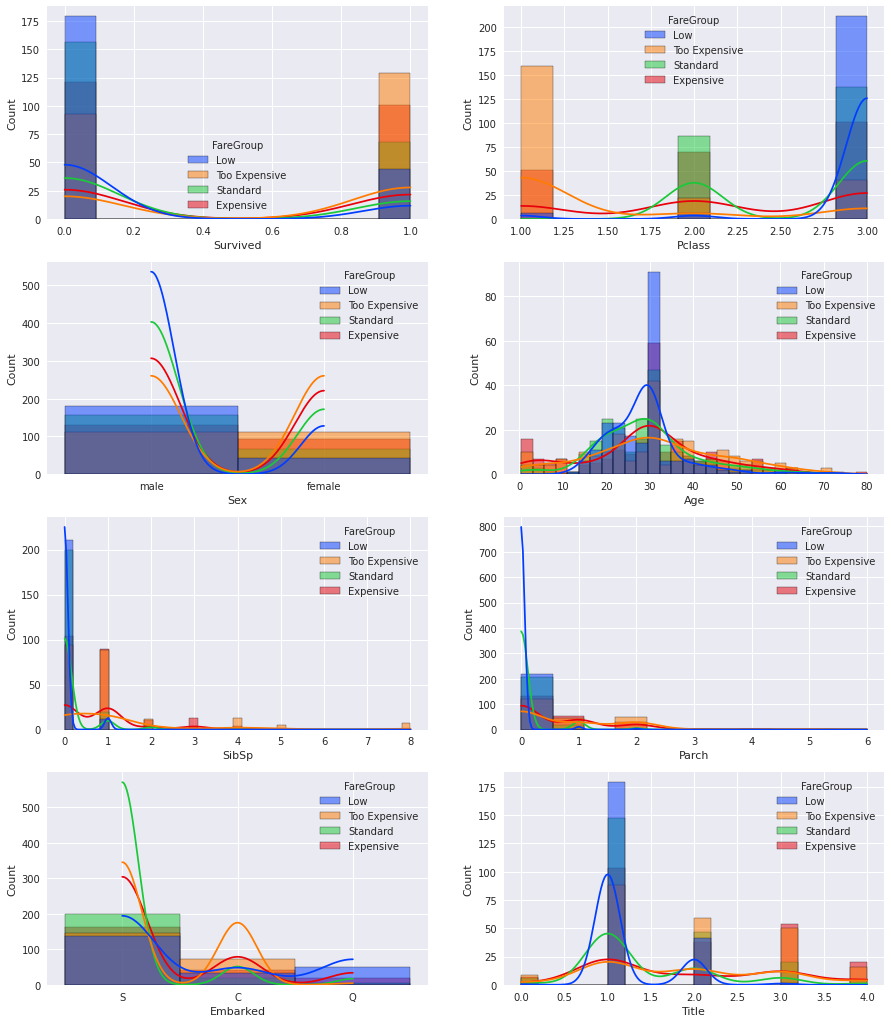

In [34]:
fig,axs = plt.subplots(4,2, figsize = (15,18))
i=1
for feature in dataset[0].columns:
    if feature not in ["PassengerId", "Name", "Ticket", "Cabin", "Fare", "FareGroup", "AgeBand"]:
        plt.subplot(4,2,i)
        sns.histplot(data=dataset[0], x=feature, kde=True, hue='FareGroup')
        i+=1

We can do some observations but the most important for me is that those people that paid higher fares had a better chance of survival than those who paid lower fares.

<AxesSubplot:xlabel='Survived', ylabel='Fare'>

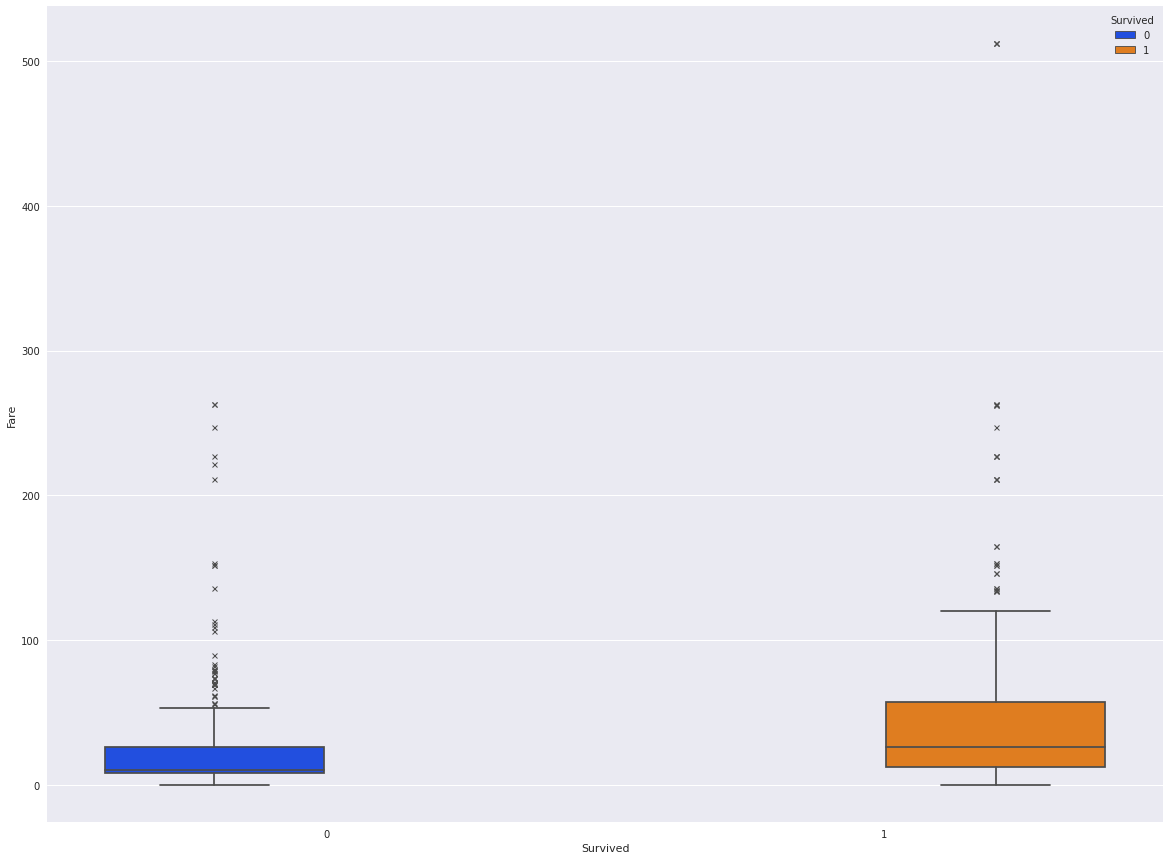

In [35]:
fig,axs = plt.subplots(1, figsize = (20,15))
sns.boxplot(data=dataset[0], x="Survived", y="Fare", hue="Survived", flierprops={"marker": "x"})

With a boxplot we can clearly see how many outliers we can find in the Fare feature. In addition, we can also see that the average rate paid by survivors is higher.

---
## Creating Features

#### Is the passenger alone?

In [36]:
for one_set in dataset:
    one_set["Alone"] = 0
    one_set["Alone"] = one_set["Alone"].astype("uint8")
    one_set.loc[((one_set["SibSp"] == 0) & (one_set["Parch"] == 0)), "Alone"] = 1
dataset[0][dataset[0]["Alone"] == 1]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,AgeBand,FareGroup,Alone
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S,2,2,Standard,1
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,NaN,S,1,3,Standard,1
5,6,0,3,"Moran, Mr. James",male,29.699118,0,0,330877,8.4583,NaN,Q,1,2,Standard,1
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.000000,0,0,17463,51.8625,E46,S,1,4,Too Expensive,1
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.000000,0,0,113783,26.5500,C103,S,2,4,Expensive,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884,885,0,3,"Sutehall, Mr. Henry Jr",male,25.000000,0,0,SOTON/OQ 392076,7.0500,NaN,S,1,2,Low,1
886,887,0,2,"Montvila, Rev. Juozas",male,27.000000,0,0,211536,13.0000,NaN,S,0,2,Standard,1
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,112053,30.0000,B42,S,2,2,Expensive,1
889,890,1,1,"Behr, Mr. Karl Howell",male,26.000000,0,0,111369,30.0000,C148,C,1,2,Expensive,1


#### Combining age and passanger classes

In [37]:
for one_set in dataset:
    one_set["AgexPclass"] = one_set["AgeBand"] * one_set["Pclass"]
dataset[0]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,AgeBand,FareGroup,Alone,AgexPclass
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,NaN,S,1,2,Low,0,6
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,C,3,3,Too Expensive,0,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S,2,2,Standard,1,6
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,S,3,3,Too Expensive,0,3
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,NaN,S,1,3,Standard,1,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.000000,0,0,211536,13.0000,NaN,S,0,2,Standard,1,4
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,112053,30.0000,B42,S,2,2,Expensive,1,2
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,29.699118,1,2,W./C. 6607,23.4500,NaN,S,2,2,Expensive,0,6
889,890,1,1,"Behr, Mr. Karl Howell",male,26.000000,0,0,111369,30.0000,C148,C,1,2,Expensive,1,2


---
## Enconding Features

In [38]:
dataset[1]["Title"] = dataset[1]["Title"].astype(np.int64)

#### Converting FareGroup from categorical to numerical:

In [39]:
fare_map = {"Low":1, "Standard":2, "Expensive":3, "Too Expensive":4}
for one_set in dataset:
    one_set["FareGroup"] = one_set["FareGroup"].map(fare_map)
    one_set['FareGroup'] = one_set['FareGroup'].fillna(0)
dataset[0]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,AgeBand,FareGroup,Alone,AgexPclass
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,NaN,S,1,2,1,0,6
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,C,3,3,4,0,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S,2,2,2,1,6
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,S,3,3,4,0,3
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,NaN,S,1,3,2,1,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.000000,0,0,211536,13.0000,NaN,S,0,2,2,1,4
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,112053,30.0000,B42,S,2,2,3,1,2
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,29.699118,1,2,W./C. 6607,23.4500,NaN,S,2,2,3,0,6
889,890,1,1,"Behr, Mr. Karl Howell",male,26.000000,0,0,111369,30.0000,C148,C,1,2,3,1,2


#### Converting Sex from categorical to numerical:

In [40]:
for one_set in dataset:
    one_set.loc[one_set["Sex"] == "male", "Sex"] = 0
    one_set.loc[one_set["Sex"] == "female", "Sex"] = 1
    one_set["Sex"] = one_set["Sex"].astype(np.int64)
dataset[0]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,AgeBand,FareGroup,Alone,AgexPclass
0,1,0,3,"Braund, Mr. Owen Harris",0,22.000000,1,0,A/5 21171,7.2500,NaN,S,1,2,1,0,6
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.000000,1,0,PC 17599,71.2833,C85,C,3,3,4,0,3
2,3,1,3,"Heikkinen, Miss. Laina",1,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S,2,2,2,1,6
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.000000,1,0,113803,53.1000,C123,S,3,3,4,0,3
4,5,0,3,"Allen, Mr. William Henry",0,35.000000,0,0,373450,8.0500,NaN,S,1,3,2,1,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",0,27.000000,0,0,211536,13.0000,NaN,S,0,2,2,1,4
887,888,1,1,"Graham, Miss. Margaret Edith",1,19.000000,0,0,112053,30.0000,B42,S,2,2,3,1,2
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",1,29.699118,1,2,W./C. 6607,23.4500,NaN,S,2,2,3,0,6
889,890,1,1,"Behr, Mr. Karl Howell",0,26.000000,0,0,111369,30.0000,C148,C,1,2,3,1,2


#### Converting Embarked from categorical to numerical:

In [41]:
for one_set in dataset:
    one_set.loc[one_set["Embarked"] == "S", "Embarked"] = 1
    one_set.loc[one_set["Embarked"] == "C", "Embarked"] = 2
    one_set.loc[one_set["Embarked"] == "Q", "Embarked"] = 3
    one_set["Embarked"] = one_set["Embarked"].astype(np.int64)
    one_set["TitlexEmbarked"] = one_set["Title"] * one_set["Embarked"] 
dataset[0]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,AgeBand,FareGroup,Alone,AgexPclass,TitlexEmbarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.000000,1,0,A/5 21171,7.2500,NaN,1,1,2,1,0,6,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.000000,1,0,PC 17599,71.2833,C85,2,3,3,4,0,3,6
2,3,1,3,"Heikkinen, Miss. Laina",1,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,1,2,2,2,1,6,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.000000,1,0,113803,53.1000,C123,1,3,3,4,0,3,3
4,5,0,3,"Allen, Mr. William Henry",0,35.000000,0,0,373450,8.0500,NaN,1,1,3,2,1,9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",0,27.000000,0,0,211536,13.0000,NaN,1,0,2,2,1,4,0
887,888,1,1,"Graham, Miss. Margaret Edith",1,19.000000,0,0,112053,30.0000,B42,1,2,2,3,1,2,2
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",1,29.699118,1,2,W./C. 6607,23.4500,NaN,1,2,2,3,0,6,2
889,890,1,1,"Behr, Mr. Karl Howell",0,26.000000,0,0,111369,30.0000,C148,2,1,2,3,1,2,2


---
## Dropping features

In [42]:
for one_set in dataset:
    one_set.drop(columns=["Name","SibSp", "Parch", "Cabin", "Ticket", "PassengerId", "Fare", "Age"], inplace=True)
dataset[0]

,Survived,Pclass,Sex,Embarked,Title,AgeBand,FareGroup,Alone,AgexPclass,TitlexEmbarked
0,0,3,0,1,1,2,1,0,6,1
1,1,1,1,2,3,3,4,0,3,6
2,1,3,1,1,2,2,2,1,6,2
3,1,1,1,1,3,3,4,0,3,3
4,0,3,0,1,1,3,2,1,9,1
...,...,...,...,...,...,...,...,...,...,...
886,0,2,0,1,0,2,2,1,4,0
887,1,1,1,1,2,2,3,1,2,2
888,0,3,1,1,2,2,3,0,6,2
889,1,1,0,2,1,2,3,1,2,2


---
## Correlations

In [43]:
dataset[0].corr()

,Survived,Pclass,Sex,Embarked,Title,AgeBand,FareGroup,Alone,AgexPclass,TitlexEmbarked
Survived,1.000000,-0.338481,0.543351,0.106811,0.467333,-0.043800,0.299357,-0.203367,-0.347927,0.394081
Pclass,-0.338481,1.000000,-0.131900,0.045702,-0.033357,-0.358769,-0.634271,0.135207,0.639717,0.014599
Sex,0.543351,-0.131900,1.000000,0.116569,0.628624,-0.070220,0.243613,-0.303646,-0.179152,0.524940
Embarked,0.106811,0.045702,0.116569,1.000000,0.034646,-0.051334,-0.098161,0.017807,-0.023747,0.627483
Title,0.467333,-0.033357,0.628624,0.034646,1.000000,-0.230490,0.312111,-0.481445,-0.225787,0.731198
AgeBand,-0.043800,-0.358769,-0.070220,-0.051334,-0.230490,1.000000,0.100443,0.123981,0.429075,-0.201971
FareGroup,0.299357,-0.634271,0.243613,-0.098161,0.312111,0.100443,1.000000,-0.560279,-0.535728,0.149315
Alone,-0.203367,0.135207,-0.303646,0.017807,-0.481445,0.123981,-0.560279,1.000000,0.254234,-0.315078
AgexPclass,-0.347927,0.639717,-0.179152,-0.023747,-0.225787,0.429075,-0.535728,0.254234,1.000000,-0.176416
TitlexEmbarked,0.394081,0.014599,0.524940,0.627483,0.731198,-0.201971,0.149315,-0.315078,-0.176416,1.000000


In [44]:
dataset[0].corr()["Survived"].abs().sort_values(ascending=False)[1:]

Sex               0.543351
Title             0.467333
TitlexEmbarked    0.394081
AgexPclass        0.347927
Pclass            0.338481
FareGroup         0.299357
Alone             0.203367
Embarked          0.106811
AgeBand           0.043800
Name: Survived, dtype: float64

---
## Training Models

In [45]:
X_train = dataset[0].drop(["Survived"], axis=1)
y_train = dataset[0]["Survived"].copy()

X_test = dataset[1]

#### Logistic Regression

In [46]:
lr = LogisticRegression(max_iter=5000)
lr.fit(X_train, y_train)

acc_lr = round(lr.score(X_train, y_train) * 100, 4)
acc_lr

81.0325

#### Support Vector Classification

In [47]:
svc = SVC(kernel='rbf', gamma=0.1, C=50)
svc.fit(X_train, y_train)

acc_svc = round(svc.score(X_train, y_train) * 100, 4)
acc_svc

86.3075

#### Nearest Neighbors

In [48]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)
acc_knn = round(knn.score(X_train, y_train) * 100, 4)
acc_knn

84.9607

#### Decission Tree

In [49]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

acc_dt = round(dt.score(X_train, y_train) * 100, 4)
acc_dt

86.9809

#### Random Forest

In [50]:
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(X_train, y_train)
rf.score(X_train, y_train)
acc_rf = round(rf.score(X_train, y_train) * 100, 4)
acc_rf

86.9809

#### XGBoost Classifier

In [51]:
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
xgb_model = xgb.XGBClassifier()
params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 200), # default 100
    "subsample": uniform(0.6, 0.4)
}

search = RandomizedSearchCV(xgb_model, param_distributions=params, random_state=42, n_iter=200, cv=3, verbose=1, n_jobs=1, return_train_score=True)

search.fit(X_train, y_train)
acc_xgb = round(search.score(X_train, y_train) * 100, 4)
acc_xgb

Fitting 3 folds for each of 200 candidates, totalling 600 fits


85.5219

In [52]:
models = pd.DataFrame({
    'Model': ["Logistic Regression", "Support Vector Classification", "K Neighbors Classifier", "Decision Tree Classifier", "Random Forest Classifier", "XGBoost Classifier"],
    'Score': [acc_lr, acc_svc, acc_knn,
              acc_dt, acc_rf, acc_xgb]})
models.sort_values(by='Score', ascending=False)

,Model,Score
3,Decision Tree Classifier,86.9809
4,Random Forest Classifier,86.9809
1,Support Vector Classification,86.3075
5,XGBoost Classifier,85.5219
2,K Neighbors Classifier,84.9607
0,Logistic Regression,81.0325


---
## Solve:

In [53]:
y_pred = rf.predict(X_test)

In [54]:
submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": y_pred
    })
submission.to_csv('./submission.csv', index=False)

In [55]:
labels = ["Survived", "No survived"]
values = [submission[submission["Survived"] == 1].count().to_numpy()[0],
         submission[submission["Survived"] == 0].count().to_numpy()[0]]

fig = go.Figure(data=[go.Pie(labels=labels, 
                             values=values, 
                             marker_colors=['cyan' ,'darkblue'],
                             textinfo='label+percent'
                            )])
fig.update(layout_title_text='Survivors', layout_showlegend=False)
fig.show()

## My position in the leaderboard at the time of editing this notebook:  
😃 Position 1958 of 14,140 teams - My submission scored 0.78468